# Get State of the Art

Here for we compare published models to get the current state of the art

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
from scipy import stats
import seaborn as sns
import gpplot
import plotnine as gg

from model_predictions import model_prediction_list
from datasets import dataset_list
from core import setup_plots

In [2]:
setup_plots()

We'll load and get unique sgRNAs for published datasets and models

In [3]:
for mp in model_prediction_list:
    mp.load_model_predictions()
    mp.set_sgrnas()

for ds in dataset_list:
    ds.load_data()
    ds.set_sgrnas()

model_datasets = model_prediction_list + dataset_list

In [4]:
model_data_summaries = []
for data in model_datasets:
    summary = dict()
    summary['name'] = data.name
    summary['data_type'] = data.classtype
    summary['n_sgRNAs'] = len(data.sgrnas)
    model_data_summaries.append(summary)

model_data_summary_df = pd.DataFrame(model_data_summaries)
model_data_summary_df.sort_values('n_sgRNAs')

,name,data_type,n_sgRNAs
12,Kim2019_test,dataset,536
9,Doench2014_human,dataset,995
15,Wang2014,dataset,1022
8,Doench2014_mouse,dataset,1168
7,Chari2015,dataset,1222
10,Doench2016,dataset,2536
1,Rule Set 2,model,4379
14,Shalem_2014,dataset,4766
13,Koike-Yusa2014,dataset,6689
6,Behan2019,dataset,7442


## Overlap between datasets and models

For each dataset and model we'll calculate the fraction of sgRNAs that each library shares with one another

In [5]:
dataset_model_overlaps = []
for ds in dataset_list:
    for m in model_prediction_list:
        dataset_model_overlap = dict()
        dataset_model_overlap['name_1'] = ds.name
        dataset_model_overlap['name_2'] = m.name
        common_sgrnas = (pd.Series(list(ds.sgrnas))
                         .isin(list(m.sgrnas))
                         .sum())
        dataset_model_overlap['overlap'] = common_sgrnas
        dataset_model_overlaps.append(dataset_model_overlap)

dataset_model_overlap_df = pd.DataFrame(dataset_model_overlaps)
dataset_model_overlap_df = dataset_model_overlap_df[dataset_model_overlap_df['overlap'] > 0].reset_index(drop=True)
dataset_model_overlap_df = (dataset_model_overlap_df.merge(model_data_summary_df
                                                           .rename({'name': 'name_1'}, axis=1),
                                                           how='inner', on='name_1')
                            .merge(model_data_summary_df
                                   .rename({'name': 'name_2'}, axis=1),
                                   how='inner', on='name_2', suffixes=('_1', '_2')))
dataset_model_overlap_df['fraction_overlap'] = dataset_model_overlap_df['overlap']/dataset_model_overlap_df['n_sgRNAs_1']

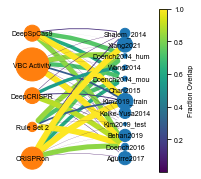

In [6]:
G = nx.from_pandas_edgelist(dataset_model_overlap_df, 'name_1', 'name_2', 'fraction_overlap',
                            create_using=nx.DiGraph())
node_n_sgrnas = (model_data_summary_df[['name', 'n_sgRNAs', 'data_type']]
                 .set_index('name')
                 .to_dict(orient='index'))
nx.set_node_attributes(G, node_n_sgrnas)
plt.subplots(figsize=(3.2,3))
# layout
pos = nx.bipartite_layout(G, [x for x, y in G.nodes(data=True) if y['data_type'] == 'model'])
# edges
edge_width = [d['fraction_overlap']*6 for u, v, d in G.edges(data=True)]
edge_color_scale = [d['fraction_overlap'] for u, v, d in G.edges(data=True)]
edges = nx.draw_networkx_edges(G, pos, arrowstyle="-", connectionstyle="arc3,rad=0.1",
                               width=edge_width, edge_color=edge_color_scale)
pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.viridis)
pc.set_array(edge_color_scale)
plt.colorbar(pc, label='Fraction Overlap')
# nodes
node_size = [d['n_sgRNAs'] * 0.02 for _, d in G.nodes(data=True)]
node_color = ['tab:blue' if d['data_type'] == 'dataset' else 'tab:orange' for _, d in G.nodes(data=True)]
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
# labels
nx.draw_networkx_labels(G, pos, font_size=7,
                        font_family='Arial')
plt.axis('off')
plt.margins(x=0.2)
gpplot.savefig('../figures/model_training_network.pdf')

## Model Performance

In [8]:
model_comparison_list = []
for i in range(len(model_prediction_list)):
    for j in range(i+1, len(model_prediction_list)):
        pred1 = model_prediction_list[i]
        pred2 = model_prediction_list[j]
        joined_predictions = pred1.prediction_df.merge(pred2.prediction_df, how='inner',
                                                       on=['sgRNA Sequence', 'sgRNA Context Sequence', 'PAM Sequence'])
        filtered_predictions = joined_predictions[~joined_predictions['sgRNA Sequence'].isin(pred1.sgrnas) &
                                                  ~joined_predictions['sgRNA Sequence'].isin(pred2.sgrnas)]
        for ds in dataset_list:
            ds_predictions = filtered_predictions.merge(ds.dataset, how='inner',
                                                        left_on=['sgRNA Sequence', 'sgRNA Context Sequence'],
                                                        right_on=[ds.sgrna_seq_col, ds.context_seq_col])
            if ds_predictions.shape[0] > 50:
                performance_dict = {}
                performance_dict['model1'] = pred1.name
                performance_dict['model2'] = pred2.name
                performance_dict['dataset'] = ds.name
                performance_dict['size'] = ds_predictions.shape[0]
                performance_dict['model1_spearman'] = stats.spearmanr(ds_predictions[pred1.prediction_col],
                                                                      ds_predictions[ds.rank_col])[0]
                performance_dict['model2_spearman'] = stats.spearmanr(ds_predictions[pred2.prediction_col],
                                                                      ds_predictions[ds.rank_col])[0]
                model_comparison_list.append(performance_dict)

performance_df = pd.DataFrame(model_comparison_list)
performance_df['difference'] = performance_df['model1_spearman'] - performance_df['model2_spearman']
model_order = ['CRISPRon', 'DeepSpCas9', 'Rule Set 2', 'VBC Activity', 'DeepCRISPR']
performance_df['model1'] = pd.Categorical(performance_df['model1'],
                                          categories=model_order)
performance_df['model2'] = pd.Categorical(performance_df['model2'],
                                          categories=model_order)
performance_df['dataset'] = performance_df['dataset'].astype('category')
performance_df.head()

,model1,model2,dataset,size,model1_spearman,model2_spearman,difference
0,DeepSpCas9,Rule Set 2,Aguirre2017,8210,0.511899,0.468766,0.043134
1,DeepSpCas9,Rule Set 2,Behan2019,7358,0.195603,0.147507,0.048096
2,DeepSpCas9,Rule Set 2,Chari2015,1193,0.445868,0.376446,0.069422
3,DeepSpCas9,Rule Set 2,Doench2014_mouse,329,0.407365,0.309187,0.098178
4,DeepSpCas9,Rule Set 2,Doench2014_human,154,0.291524,0.278753,0.012772


We can see that DeepSpCas9 consistently outperforms Rule Set 2, and DeepCRISPR is consistently the worst model

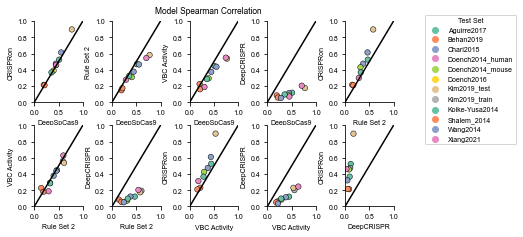

In [14]:
def const_line(ax, *args, **kwargs):
    ax.plot([0, 1], [0, 1], color='black')

fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(5.5, 3))
fig.tight_layout()
for i, (group, group_df) in enumerate(performance_df
                                      .sort_values(['model1', 'model2'])
                                      .groupby(['model1', 'model2'])):
    ax = axs[i//5, i % 5]
    sns.scatterplot(data=group_df,
                    x='model1_spearman', y='model2_spearman',
                    hue='dataset', palette='Set2',
                    edgecolor='black', linewidth=0.5, ax=ax,
                    s=30)
    ax.get_legend().remove()
    const_line(ax)
    ax.set(xlim=(0,1), ylim=(0,1),
           xlabel=group[0], ylabel=group[1])
    sns.despine(ax=ax)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.04,1), loc="upper left",
           title='Test Set')
fig.suptitle('Model Spearman Correlation', va='bottom')
gpplot.savefig('../figures/model_performance.pdf')


In [9]:
performance_comparison_df = performance_df.copy()
performance_comparison_df['comparison'] = (performance_df['model1'].astype(str) + '_' +
                                           performance_df['model2'].astype(str))
performance_df_model1 = (performance_comparison_df[['model1', 'model1_spearman', 'dataset', 'size', 'comparison']]
                         .copy()
                         .rename({'model1': 'model', 'model1_spearman': 'spearman'}, axis=1))
performance_df_model2 = (performance_comparison_df[['model2', 'model2_spearman', 'dataset', 'size', 'comparison']]
                         .copy()
                         .rename({'model2': 'model', 'model2_spearman': 'spearman'}, axis=1))
long_performance_df = (pd.concat([performance_df_model1, performance_df_model2])
                       .reset_index(drop=True))
long_performance_df['dataset'] = long_performance_df['dataset'].astype('str')
model_average_performance = (long_performance_df.groupby('model')
                             .agg({'spearman': 'mean'})
                             .sort_values('spearman')
                             .reset_index())
dataset_max_size = (long_performance_df.groupby('dataset')
                    .agg({'size': 'max'})
                    .sort_values('size')
                    .reset_index())
comparison_average_performance = (long_performance_df.groupby('comparison')
                                  .agg({'spearman': 'mean'})
                                  .sort_values('spearman')
                                  .reset_index())
long_performance_df['model'] = pd.Categorical(long_performance_df['model'],
                                              categories=model_average_performance['model'])
long_performance_df['dataset'] = pd.Categorical(long_performance_df['dataset'],
                                                categories=dataset_max_size['dataset'])
long_performance_df['comparison'] = pd.Categorical(long_performance_df['comparison'],
                                                   categories=comparison_average_performance['comparison'])

In [10]:
g = (gg.ggplot(long_performance_df) +
     gg.aes(y='model', x='dataset', fill='spearman') +
     gg.geom_tile(color='black') +
     gg.scale_fill_cmap('RdBu_r', limits=(-1, 1)) +
     gg.guides(fill=gg.guide_colorbar(barwidth=10, barheight=10,
                                          title='Spearman r', raster=True)) +
     gg.theme(axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1),
              strip_text=gg.element_blank(),
              subplots_adjust={'wspace': 0.6},
              plot_background=gg.element_blank()) +
     gg.facet_wrap('comparison', scales='free_y', nrow=3) +
     gg.ylab('Model') +
     gg.xlab('Dataset'))
g.save('../figures/model_performance_heatmap.pdf', width=4, height=2.25)
g

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 2.25 in image.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/model_performance_heatmap.pdf


TypeError: '<' not supported between instances of 'float' and 'str'

In [ ]:
average_difference = (performance_df.groupby(['model1', 'model2'])
                      .apply(lambda df: ((df['model1_spearman'] - df['model2_spearman'])*df['size']).sum()/
                                        df['size'].sum())
                      .reset_index(name='avg_difference'))
average_difference.sort_values(['model1', 'model2'])

## Picking training data
Since DeepSpCas9 is the current state of the art, we'll start with the Kim2019_train data as our training seed,
and then include all data with more than 50% overlap with the Kim2019_train data,
as well as the Wang2014 data to expand the training set.


In [ ]:
dataset_overlaps = []
for ds1 in dataset_list:
    for ds2 in dataset_list:
        if ds1 != ds2:
            dataset_overlap = dict()
            dataset_overlap['name_1'] = ds1.name
            dataset_overlap['name_2'] = ds2.name
            common_context = (ds1.dataset[ds1.context_seq_col]
                              .isin(ds2.dataset[ds2.context_seq_col])
                              .sum())
            dataset_overlap['overlap'] = common_context
            dataset_overlaps.append(dataset_overlap)

dataset_overlap_df = pd.DataFrame(dataset_overlaps)
dataset_overlap_df = dataset_overlap_df[dataset_overlap_df['overlap'] > 0].reset_index(drop=True)
# directional overlap
dataset_overlap_df = (dataset_overlap_df.merge(model_data_summary_df
                                               .rename({'name': 'name_1'}, axis=1),
                                               how='inner', on='name_1'))
dataset_overlap_df['fraction_overlap'] = dataset_overlap_df['overlap']/dataset_overlap_df['n_sgRNAs']

In [ ]:
def get_overlapping_datasets(datasets, sink_node, data, threshold=0.2):
    """Recursively get datasets which overlap with sink_node greater than a give threshold

    :param datasets: list
    :param sink_node: str
    :param data: DataFrame
    :param threshold: float
    """
    datasets.append(sink_node)
    overlapping_nodes = data.loc[(data['name_2'] == sink_node) &
                                 (data['fraction_overlap'] > threshold), 
                                 'name_1'].to_list()
    if len(overlapping_nodes) != 0:
        filtered_data = data[~data['name_1'].isin(overlapping_nodes)].copy()
        for node in overlapping_nodes:
            get_overlapping_datasets(datasets, node, filtered_data, threshold)
            
train_datasets = []
get_overlapping_datasets(train_datasets, 'Kim2019_train', dataset_overlap_df)
get_overlapping_datasets(train_datasets, 'Wang2014', dataset_overlap_df)
train_datasets

In [ ]:
sgrna_train_dfs_list = list()
sgrna_test_dfs_list = list()
for ds in dataset_list:
    if ds.name in train_datasets:
        sgrna_train_dfs_list.append(ds.get_sg_df())
    else:
        sgrna_test_dfs_list.append(ds.get_sg_df())
        

train_sgrna_df = (pd.concat(sgrna_train_dfs_list)
                  .drop_duplicates())
test_sgrna_df = (pd.concat(sgrna_test_dfs_list)
                 .drop_duplicates())
print("Train sgRNAs: " + str(train_sgrna_df.shape[0]))
print("Test sgRNAs: " + str(test_sgrna_df.shape[0]))

In [ ]:
data_summary_df = model_data_summary_df.loc[model_data_summary_df['data_type'] == 'dataset',
                                            ['name', 'n_sgRNAs']].copy()
data_summary_df['Train'] = data_summary_df['name'].isin(train_datasets)

In [ ]:
G = nx.from_pandas_edgelist(dataset_overlap_df, 'name_1', 'name_2', 'fraction_overlap',
                            create_using=nx.DiGraph())
node_n_sgrnas = (data_summary_df
                 .set_index('name')
                 .to_dict(orient='index'))
nx.set_node_attributes(G, node_n_sgrnas)
plt.subplots(figsize=(3.2,3))
# layout
pos = nx.spring_layout(G, seed=2)
# edges
edge_width = [d['fraction_overlap']*6 for u, v, d in G.edges(data=True)]
edge_color_scale = [d['fraction_overlap'] for u, v, d in G.edges(data=True)]
edges = nx.draw_networkx_edges(G, pos, arrowstyle="-", connectionstyle="arc3,rad=0.1",
                               width=edge_width, edge_color=edge_color_scale,
                               arrowsize=5)
pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.viridis)
pc.set_array(edge_color_scale)
plt.colorbar(pc, label='Fraction Overlap')
# nodes
node_size = [d['n_sgRNAs'] * 0.02 for _, d in G.nodes(data=True)]
node_color = ['tab:blue' if d['Train'] else 'tab:orange' for _, d in G.nodes(data=True)]
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
# labels
nx.draw_networkx_labels(G, pos, font_size=7,
                        font_family='Arial')
plt.axis('off')
plt.margins(x=0.2)
gpplot.savefig('../figures/train_dataset_network.svg')


## Write list of training data

In [ ]:
train_data_name_df = pd.DataFrame({'name': train_datasets})
train_data_name_df.to_csv('../data/processed/train_data_names.csv', index=False)